In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
def smart_money_sumd(df, window=60):
    """
    改进2：融合主力资金流向
    金融逻辑：跟随聪明钱(taker buy)的动向比跟随整体成交量更有效
    改进点：使用taker buy volume代替总成交量，识别主力动向
    """
    close = df['close'] 
    price_diff = close.diff()
    
    taker_ratio = df['taker_buy_volume'] / df['volume'].replace(0, 1e-12)
    
    # 主力资金方向加权的价格变动
    gain = (price_diff * taker_ratio).where(price_diff > 0, 0)
    # 当价格上涨时，主力资金的买入量对价格上涨的贡献
    loss = (-price_diff * (1 - taker_ratio)).where(price_diff < 0, 0)
    # 当价格下跌时，主力资金的卖出量对价格下跌的贡献
    
    sum_gain = gain.rolling(window).sum()
    sum_loss = loss.rolling(window).sum()
    
    # 加入市场情绪调整
    market_strength = (df['high'] - df['low']).rolling(window).mean() + 1e-12
    factor = (sum_gain - sum_loss) / market_strength
    
    return factor

# 因子测试

In [29]:
evaluator.set_factor(
    factor_func=smart_money_sumd,
    factor_name='smart_money_sumd'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.019660
   Rank_IC (Spearman): -0.023837
📊 信息比率:
   IR: 0.424648
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130695
   因子列: smart_money_sumd
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


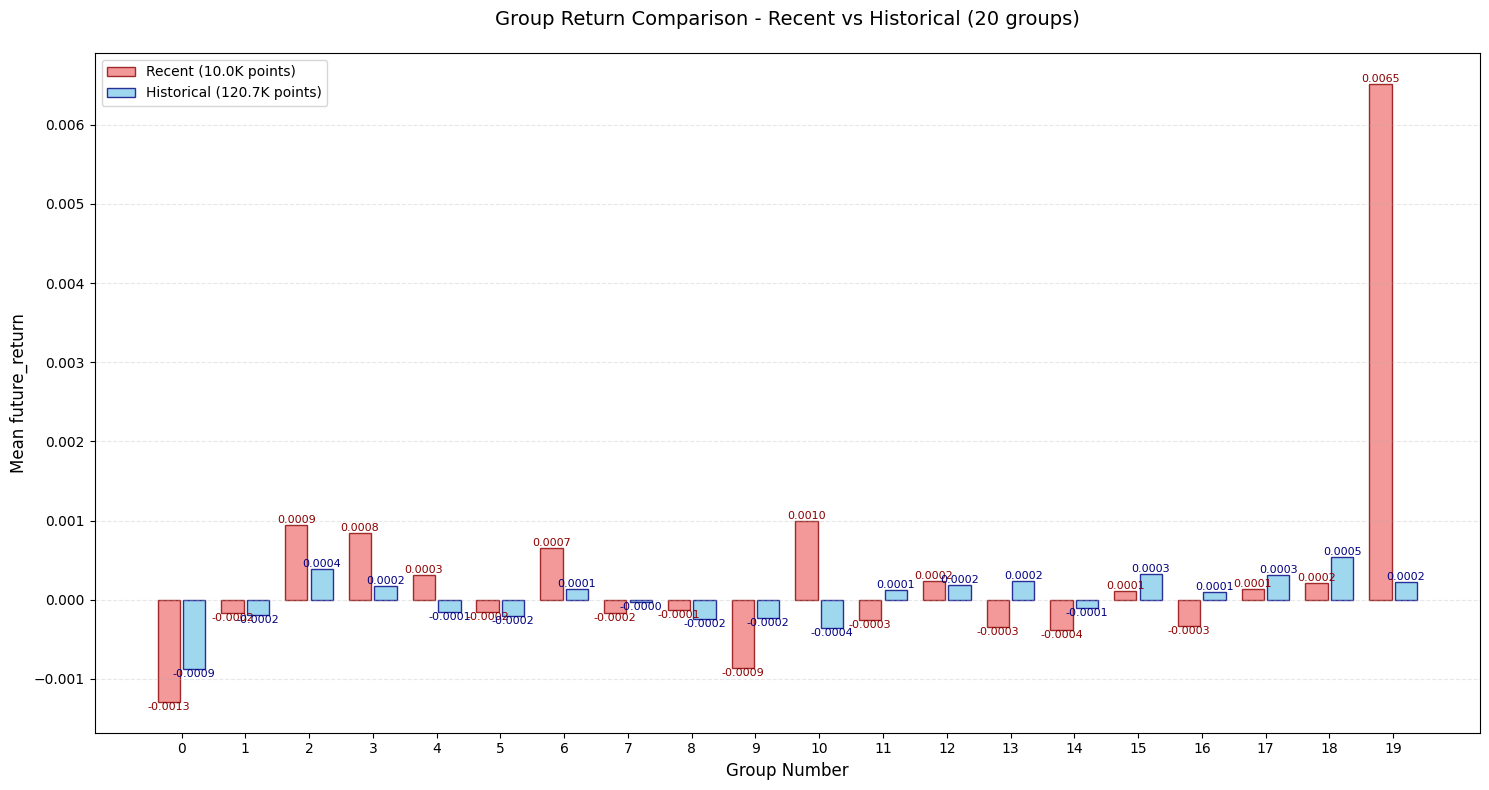

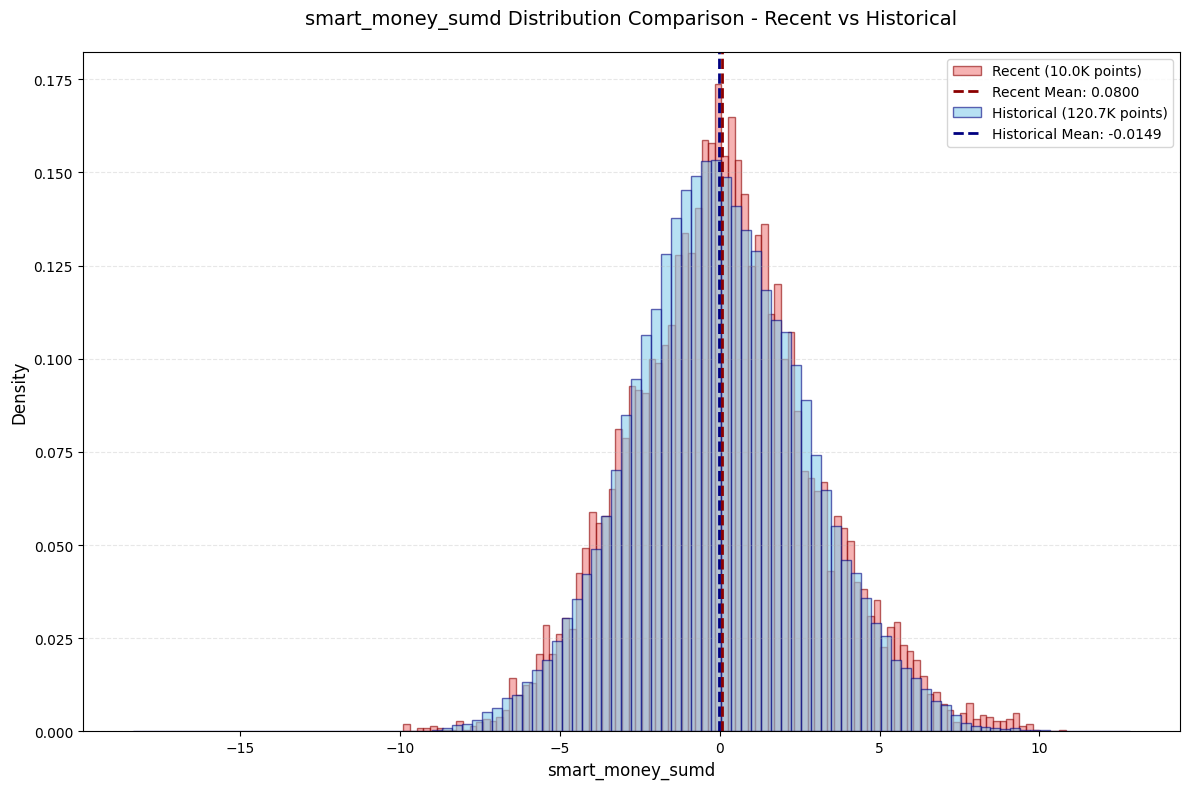

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [30]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [31]:
print(result)

{'correlation_analysis': {'IC': 0.019659978033031, 'Rank_IC': -0.023836890965278915}, 'information_ratio': {'IR': 0.4246483196391175, 'group_correlations': [0.010955848497705454, -0.004531516907121805, -0.0045049634100033185, -0.004277235053900314, -0.0048949814402422225, 0.015222623772792687, -0.006908541114916204, 0.019360375543303738, 0.004871240554857492, 0.016969120420170347], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -18.3721  -4.4754   -5.6257      -0.0009      0.0168   6535
1      -4.4754  -3.4308   -3.9088      -0.0002      0.0128   6535
2      -3.4307  -2.7778   -3.0853       0.0004      0.0129   6535
3      -2.7778  -2.2654   -2.5137       0.0002      0.0118   6534
4      -2.2654  -1.8157   -2.0379      -0.0001      0.0118   6535
5      -1.8155  -1.4285   -1.6183      -0.0002      0.0112   6535
6      -1.4284  -1.0688   -1.2465   